# Data Analysis for Stock Simulation

This notebook compiles statistics on the performance of each trading strategy as well as overall performance versus changes in the asset price. It:

- Loads the CSV files (`price_data.csv` and `agent_wealth.csv`) generated during simulation
- Reconstructs agent strategy assignments (based on our simulation’s round-robin order for the first 100 agents, plus special arbitrage agents)
- Computes summary statistics (mean, median, standard deviation, min, max) for final wealth by strategy
- Plots overall asset price vs. average agent wealth over time
- Examines the correlation between price changes and wealth changes
and finally produces box plots of the final wealth distribution per strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV files generated by the simulation
price_data = pd.read_csv('Data/price_data.csv', index_col=0)
wealth_data = pd.read_csv('Data/agent_wealth.csv', index_col=0)

# Preview the imported data
print("Price Data:")
print(price_data.head())

print("\nWealth Data (agents over ticks):")
print(wealth_data.head())

Price Data:
       Price  Trades
0  98.773606      22
1  98.177062       9
2  97.412965      14
3  96.775058      13
4  96.227721      11

Wealth Data (agents over ticks):
           0            1       2       3       4       5            6  \
Step                                                                     
1     1000.0  1000.002000  1000.0  1000.0  1000.0  1000.0  1000.016000   
2     1000.0   999.405456  1000.0  1000.0  1000.0  1000.0   999.421456   
3     1000.0   998.641359  1000.0  1000.0  1000.0  1000.0   997.905262   
4     1000.0   998.003452  1000.0  1000.0  1000.0  1000.0   995.995542   
5     1000.0   997.456115  1000.0  1000.0  1000.0  1000.0   993.807193   

           7       8            9  ...           91      92      93      94  \
Step                               ...                                        
1     1000.0  1000.0  1000.000000  ...  1000.003000  1000.0  1000.0  1000.0   
2     1000.0  1000.0  1000.000000  ...   999.406456  1000.0  1000.0  100

## Agent Strategy Assignment

In the simulation, agents were assigned to strategies as follows:

- **Agents 0–99** (assuming 100 agents) are assigned in a round-robin order to:
  - TrendFollowingStrategy
  - MeanReversionStrategy
  - MomentumStrategy
  - BreakoutStrategy
  - ValueInvestingStrategy

- **Arbitrage agents** are appended following these (starting with agent ID 100).

We reconstruct the strategy for each agent using its ID.

In [2]:
# Set parameters (should match the simulation run)
num_agents = 100  # agents with IDs 0-99

# Function to get the strategy name based on agent id
def get_strategy_name(agent_id):
    if agent_id < num_agents:
        strategies = ['TrendFollowing', 'MeanReversion', 'Momentum', 'Breakout', 'ValueInvesting']
        return strategies[agent_id % len(strategies)]
    else:
        return 'Arbitrage'

# Extract final wealth for each agent from the last tick
final_wealth = wealth_data.iloc[-1]
strategy_map = {int(agent): get_strategy_name(int(agent)) for agent in wealth_data.columns}

# Create a DataFrame for final wealth per agent along with their strategy
agent_performance = pd.DataFrame({
    'AgentID': [int(a) for a in wealth_data.columns],
    'FinalWealth': final_wealth.values,
    'Strategy': [strategy_map[int(a)] for a in wealth_data.columns]
})

print("Agent Performance (Final Wealth):")
agent_performance.head()

Agent Performance (Final Wealth):


,AgentID,FinalWealth,Strategy
0,0,3233.949976,TrendFollowing
1,1,251.450445,MeanReversion
2,2,3896.499097,Momentum
3,3,1053.547794,Breakout
4,4,568.410988,ValueInvesting


## Performance Statistics by Strategy

We now group the agents by their strategy and compute summary statistics: mean, median, standard deviation, minimum, and maximum of final wealth.

In [3]:
performance_stats = agent_performance.groupby('Strategy')['FinalWealth'].agg(['mean', 'median', 'std', 'min', 'max'])
print("\nPerformance Statistics by Strategy:")
print(performance_stats)


Performance Statistics by Strategy:
                        mean        median         std           min  \
Strategy                                                               
Arbitrage       65075.525249  65075.525249         NaN  65075.525249   
Breakout         1508.198820   1327.853363  487.920712   1037.434329   
MeanReversion     199.554145    193.739681   16.313100    172.964374   
Momentum         4027.358144   4139.645028  542.878505   3001.328253   
TrendFollowing   3005.013461   3081.762754  280.435396   2585.474560   
ValueInvesting    657.541106    622.008734  194.869253    337.557090   

                         max  
Strategy                      
Arbitrage       65075.525249  
Breakout         2532.518474  
MeanReversion     251.450445  
Momentum         5168.924088  
TrendFollowing   3474.130441  
ValueInvesting   1103.925979  


## Overall Performance vs. Change in Price

The notebook now calculates the average wealth over time across all agents and compares it to the asset price. We then compute the percentage changes and a correlation between price changes and wealth changes.

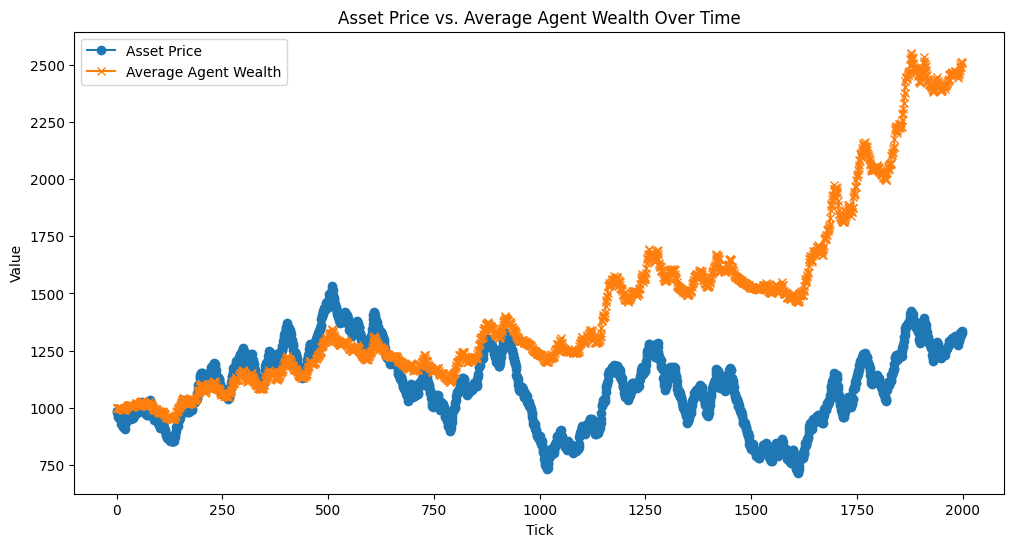

Correlation between price change and average wealth change: 0.9185


In [4]:
# Compute average agent wealth per tick (across all agents)
avg_wealth_over_time = wealth_data.mean(axis=1)

# Plot asset price vs. average agent wealth over time
ticks = price_data.index.astype(int)

plt.figure(figsize=(12,6))
plt.plot(ticks, price_data['Price']*10, marker='o', label='Asset Price')
plt.plot(ticks, avg_wealth_over_time, marker='x', label='Average Agent Wealth')
plt.xlabel('Tick')
plt.ylabel('Value')
plt.title('Asset Price vs. Average Agent Wealth Over Time')
plt.legend()
plt.show()

# Calculate percentage change in asset price between ticks
price_data['PriceChangePct'] = price_data['Price'].pct_change()

# Calculate percentage change in average wealth
avg_wealth_change = avg_wealth_over_time.pct_change()

# Compute correlation (drop the NaN values from percentage change computations)
correlation = np.corrcoef(price_data['PriceChangePct'].dropna(), avg_wealth_change.dropna())[0, 1]
print(f"Correlation between price change and average wealth change: {correlation:.4f}")

## Distribution of Final Wealth by Strategy

A box plot below shows the distribution of final wealth for each trading strategy.

<Figure size 1000x600 with 0 Axes>

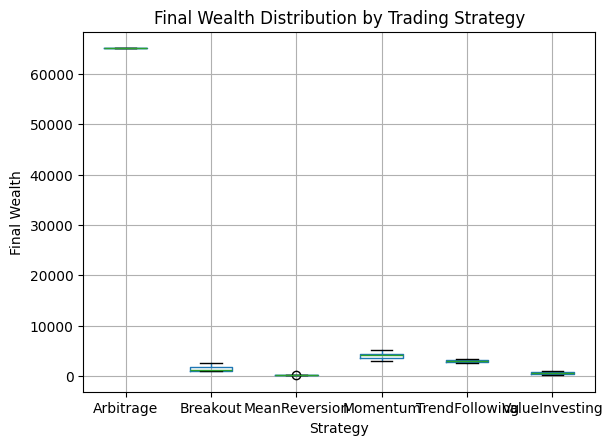

In [5]:
plt.figure(figsize=(10,6))
agent_performance.boxplot(column='FinalWealth', by='Strategy')
plt.title('Final Wealth Distribution by Trading Strategy')
plt.suptitle('')
plt.xlabel('Strategy')
plt.ylabel('Final Wealth')
plt.show()

## Agents Average Wealth
This shows the average agent wealth by type per tick

      Breakout  MeanReversion  Momentum  TrendFollowing  ValueInvesting
Step                                                                   
1       1000.0    1000.012650    1000.0          1000.0     1000.000000
2       1000.0     999.358702    1000.0          1000.0     1000.000000
3       1000.0     998.179401    1000.0          1000.0     1000.000200
4       1000.0     996.779806    1000.0          1000.0      999.969055
5       1000.0     995.277179    1000.0          1000.0      999.887704


C:\Users\Kyle\AppData\Local\Temp\ipykernel_13496\689509454.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_wealth_by_strategy = wealth_data_int.groupby(by=strategy_series, axis=1).mean()


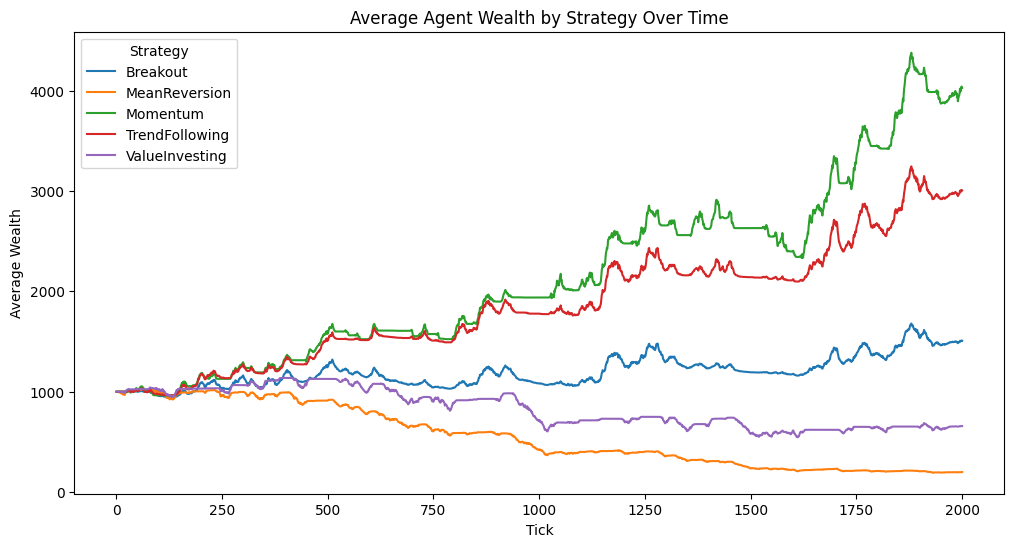

In [6]:
# Average agent wealth by strategy per tick

# Assume `wealth_data` (DataFrame indexed by tick, columns=agent IDs) 
# and `strategy_map` (dict mapping int(agent_id) → strategy string) are already defined.

# Convert columns to integers
wealth_data_int = wealth_data.copy()
wealth_data_int.columns = wealth_data_int.columns.astype(int)

# Create a Series mapping agent IDs → strategy
strategy_series = pd.Series(strategy_map)

# Group by strategy and compute mean wealth per tick
avg_wealth_by_strategy = wealth_data_int.groupby(by=strategy_series, axis=1).mean()

if 'Arbitrage' in avg_wealth_by_strategy.columns:
    avg_wealth_by_strategy = avg_wealth_by_strategy.drop(columns='Arbitrage')

# Display the first few rows
print(avg_wealth_by_strategy.head())

# Optional: plot the result
plt.figure(figsize=(12,6))
for strat in avg_wealth_by_strategy.columns:
    plt.plot(avg_wealth_by_strategy.index.astype(int),
             avg_wealth_by_strategy[strat],
             label=strat)
plt.xlabel('Tick')
plt.ylabel('Average Wealth')
plt.title('Average Agent Wealth by Strategy Over Time')
plt.legend(title='Strategy')
plt.show()


## Summary

This analysis provided:

- Summary statistics for each trading strategy's final wealth
- A time-series comparison of the asset price and average agent wealth
- A computation of correlation between asset price changes and agent wealth changes
  
You can extend this analysis further by incorporating trade log details if you export that information from the simulation

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13496\96274455.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positives[non_arb_ids],
C:\Users\Kyle\AppData\Local\Temp\ipykernel_13496\96274455.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  above_thresh[non_arb_ids],
C:\Users\Kyle\AppData\Local\Temp\ipykernel_13496\96274455.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positives[arb_id],
C:\Users\Kyle\AppData\Local\Temp\

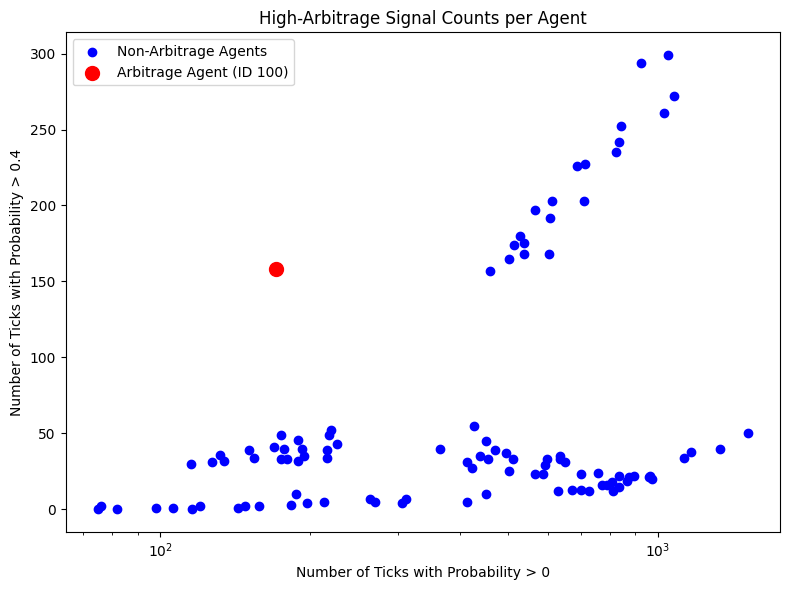

In [7]:
# 1. Load arbitrage probability data
arb_prob = pd.read_csv('Data/arbitrage_probabilities.csv', index_col=0)

# 2. Select only numeric probability columns
arb_num = arb_prob.select_dtypes(include=[float, int])

# 3. Compute per-agent counts
positives    = (arb_num > 0).sum(axis=0)    # number of ticks with prob > 0
above_thresh = (arb_num > 0.4).sum(axis=0)  # number of ticks with prob > 0.4

# 4. Identify agent IDs (assuming last column is the arbitrage agent)
agent_ids   = arb_num.columns.astype(int).tolist()
non_arb_ids = agent_ids[:-1]
arb_id      = agent_ids[-1]

# 5. Plot all non-arbitrage agents in blue
plt.figure(figsize=(8,6))
plt.scatter(
    positives[non_arb_ids],
    above_thresh[non_arb_ids],
    color='blue',
    label='Non‐Arbitrage Agents'
)

# 6. Plot the arbitrage agent in red (and make it larger)
plt.scatter(
    positives[arb_id],
    above_thresh[arb_id],
    color='red',
    s=100,
    label=f'Arbitrage Agent (ID {arb_id})'
)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Ticks with Probability > 0')
plt.ylabel('Number of Ticks with Probability > 0.4')
plt.title('High-Arbitrage Signal Counts per Agent')
plt.legend()
plt.tight_layout()
plt.show()

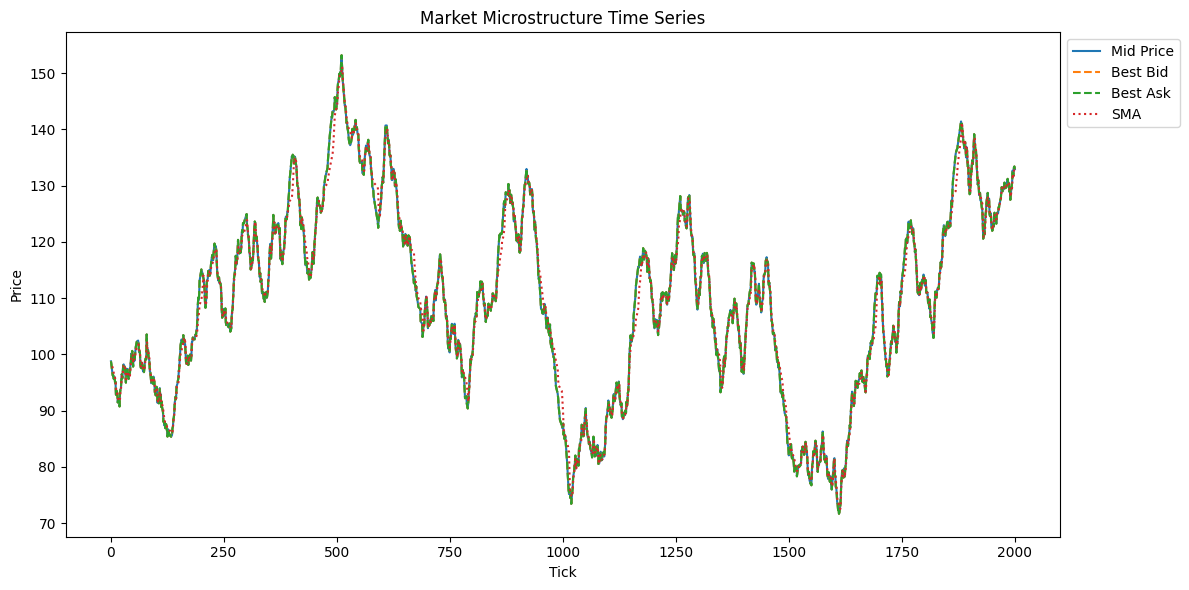

In [8]:
df = pd.read_csv('data/trade_ledger_detailed.csv')

# Aggregate by tick to get one market snapshot per tick
tick_stats = (
    df
    .groupby('tick')
    .agg(
        mid_price=('mid_price', 'mean'),
        best_bid=('best_bid', 'mean'),
        best_ask=('best_ask', 'mean'),
        sma=('sma', 'mean')
    )
    .reset_index()
)

# Plot market microstructure over time
plt.figure(figsize=(12, 6))
plt.plot(tick_stats['tick'], tick_stats['mid_price'], label='Mid Price')
plt.plot(tick_stats['tick'], tick_stats['best_bid'], linestyle='--', label='Best Bid')
plt.plot(tick_stats['tick'], tick_stats['best_ask'], linestyle='--', label='Best Ask')
plt.plot(tick_stats['tick'], tick_stats['sma'], linestyle=':', label='SMA')

plt.title('Market Microstructure Time Series')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_13496\249436560.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  avg_by_strat = wealth_int.groupby(by=strategy_series, axis=1).mean()


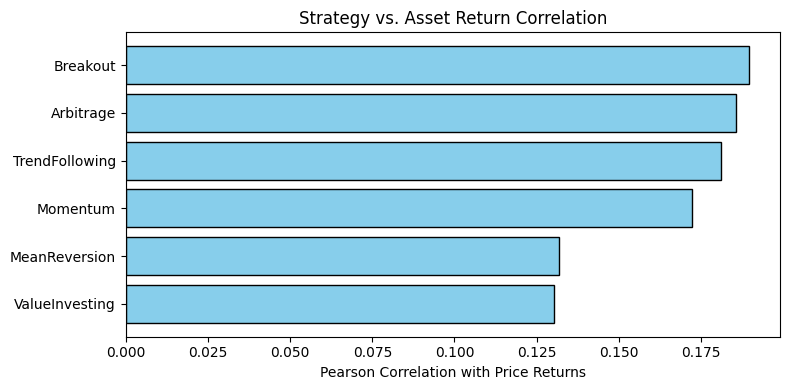

In [9]:
wealth_int = wealth_data.copy()
wealth_int.columns = wealth_int.columns.astype(int)
strategy_series = pd.Series(strategy_map)
avg_by_strat = wealth_int.groupby(by=strategy_series, axis=1).mean()

# 2. Compute percent-changes
price_pct = price_data['Price'].pct_change().dropna()
strat_pct = avg_by_strat.pct_change().dropna()

# 3. Align on common ticks
common = price_pct.index.intersection(strat_pct.index)
price_pct = price_pct.loc[common]
strat_pct = strat_pct.loc[common]

# 4. Compute Pearson correlation of each strategy vs. price returns
corrs = strat_pct.corrwith(price_pct)

# 5. Build correlation table sorted by value
corr_table = (
    pd.DataFrame({
        'Strategy': corrs.index,
        'Price_Return_Correlation': corrs.values
    })
    .set_index('Strategy')
    .sort_values('Price_Return_Correlation')
)

# 6. Plot horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(
    corr_table.index,
    corr_table['Price_Return_Correlation'],
    color='skyblue',
    edgecolor='k'
)
plt.axvline(0, color='gray', linewidth=0.8)  # zero reference line
plt.xlabel('Pearson Correlation with Price Returns')
plt.title('Strategy vs. Asset Return Correlation')
plt.tight_layout()
plt.show()